# Comparação entre o modelo MTL com o uso de embeddings HGI e HMMR


**Configurações usadas**

### **InputsConfig**  
- **EMBEDDING_DIM**: 64  
- **SLIDE_WINDOW**: 9  
- **PAD_VALUE**: 0  
- **TIMEOUT_TEST**: None  
- **NEXT_TARGET**: None  
- **CATEGORY_TARGET**: None  

---

### **MTLModelConfig**  
- **NUM_CLASSES**: 7  
- **BATCH_SIZE**: 2048  
- **EPOCHS**: 50  
- **LEARNING_RATE**: 0.0001  
- **K_FOLDS**: 3  

---

### **ModelParameters**  
- **INPUT_DIM**: 64
- **SHARED_LAYER_SIZE**: 256  
- **NUM_HEADS**: 8  
- **NUM_LAYERS**: 4  
- **SEQ_LENGTH**: 9  
- **NUM_SHARED_LAYERS**: 4  
- **ENCODER_OUTPUT_SIZE**: 256  
- **EXPERT_HIDDEN_SIZE**: 256  
- **EXPERT_OUTPUT_SIZE**: 256  
- **NUM_EXPERTS**: 9  


# Montana

In [40]:
ESTADO = "montana"

## HGI

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9531,-0.328018,-0.279717,-0.268858,-0.025124,-0.033602,0.831421,0.487451,0.345670,-0.051999,...,0.382835,0.569170,0.062280,-0.175719,0.631150,-0.055097,0.027944,0.636096,0.206160,Shopping
1,9532,-0.212724,-0.188304,-0.040483,-0.244203,1.012444,1.173037,-0.368704,-0.216277,0.044884,...,-0.090151,0.303618,0.442501,-0.290301,0.510194,-0.057238,-0.213825,0.169952,0.980230,Community
2,9533,0.957083,-0.120902,0.103594,-0.226602,0.106776,0.596069,-0.405396,0.028514,0.509419,...,-0.079732,0.831397,0.024735,-0.035905,0.493928,-0.049237,1.114538,-0.022972,0.607717,Outdoors
3,9593,-0.033946,0.299042,0.101730,-0.204093,0.044489,0.653744,0.662394,0.550874,0.672326,...,-0.085716,0.441036,0.209071,1.268344,-0.063430,-0.185252,0.540702,0.180796,-0.019045,Travel
4,9693,0.615521,-0.025080,-0.066807,-0.233809,-0.017595,0.547271,-0.263094,-0.132398,-0.088840,...,-0.188026,1.086916,-0.036607,-0.170019,0.699518,-0.245074,0.281830,-0.058471,0.175323,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,7565433,-0.317049,-0.118215,-0.024992,-0.075344,-0.097142,0.470303,1.184643,-0.310203,0.385223,...,1.237868,-0.138529,1.750363,-0.187174,0.915760,-0.043957,0.691891,0.626277,0.029799,Food
10265,7568997,0.111724,-0.083904,0.190910,0.032612,-0.245301,0.713871,1.140990,-0.011070,-0.039734,...,0.244286,-0.005502,0.883621,-0.288049,0.223249,-0.191501,0.471388,-0.290527,0.050230,Shopping
10266,7570992,0.049874,-0.004915,-0.391894,0.467625,0.852172,0.454604,0.777993,0.827893,-0.138480,...,0.350916,0.725459,-0.101077,-0.175795,1.246596,0.750474,0.479635,-0.163431,-0.023801,Travel
10267,7574223,-0.295706,0.242828,-0.606082,-0.171838,1.712261,0.892785,1.275130,0.676823,1.093236,...,2.273987,-0.580897,1.323805,0.547652,2.097080,-0.205113,0.026762,-0.269167,0.473824,Food


## Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

## Sumário do Treino

In [41]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [42]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,64.08 ± 14.18,66.26 ± 8.50,64.53 ± 9.53,3266.67 ± 57.74
1,Entertainment,47.29 ± 18.12,19.37 ± 0.55,26.92 ± 3.10,2066.67 ± 57.74
2,Food,71.58 ± 3.02,76.38 ± 5.53,73.78 ± 2.55,13966.67 ± 57.74
3,Nightlife,57.85 ± 7.62,54.76 ± 5.46,55.84 ± 2.63,2800.00 ± 0.00
4,Outdoors,67.92 ± 9.16,69.19 ± 3.08,68.28 ± 4.81,3133.33 ± 57.74


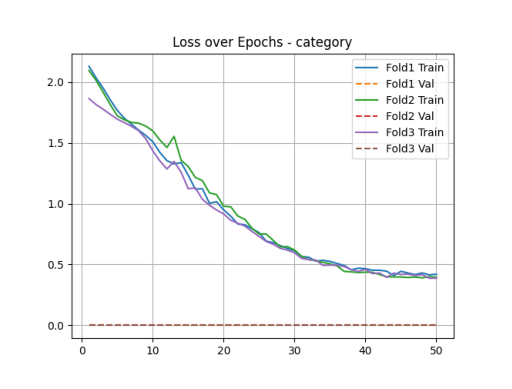

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [44]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.78 ± 2.75,75.65 ± 10.08,62.55 ± 2.40,4366.67 ± 57.74
1,Entertainment,18.84 ± 4.09,23.21 ± 9.28,20.62 ± 6.35,733.33 ± 57.74
2,Food,41.92 ± 8.34,12.22 ± 10.84,16.87 ± 13.45,6000.00 ± 0.00
3,Nightlife,34.44 ± 15.03,24.36 ± 8.41,26.27 ± 4.81,1233.33 ± 57.74
4,Outdoors,32.06 ± 7.78,54.03 ± 18.45,39.60 ± 9.67,1533.33 ± 57.74


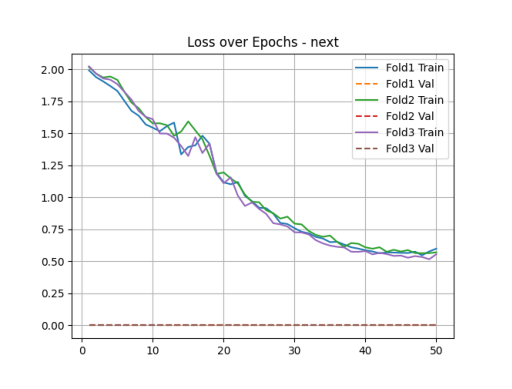

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

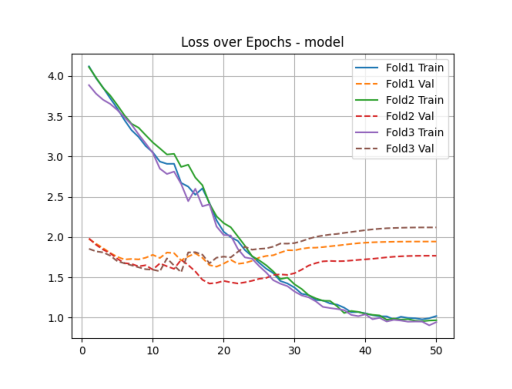

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# California

In [47]:
ESTADO = "california"

## HGI

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9531,-0.328018,-0.279717,-0.268858,-0.025124,-0.033602,0.831421,0.487451,0.345670,-0.051999,...,0.382835,0.569170,0.062280,-0.175719,0.631150,-0.055097,0.027944,0.636096,0.206160,Shopping
1,9532,-0.212724,-0.188304,-0.040483,-0.244203,1.012444,1.173037,-0.368704,-0.216277,0.044884,...,-0.090151,0.303618,0.442501,-0.290301,0.510194,-0.057238,-0.213825,0.169952,0.980230,Community
2,9533,0.957083,-0.120902,0.103594,-0.226602,0.106776,0.596069,-0.405396,0.028514,0.509419,...,-0.079732,0.831397,0.024735,-0.035905,0.493928,-0.049237,1.114538,-0.022972,0.607717,Outdoors
3,9593,-0.033946,0.299042,0.101730,-0.204093,0.044489,0.653744,0.662394,0.550874,0.672326,...,-0.085716,0.441036,0.209071,1.268344,-0.063430,-0.185252,0.540702,0.180796,-0.019045,Travel
4,9693,0.615521,-0.025080,-0.066807,-0.233809,-0.017595,0.547271,-0.263094,-0.132398,-0.088840,...,-0.188026,1.086916,-0.036607,-0.170019,0.699518,-0.245074,0.281830,-0.058471,0.175323,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,7565433,-0.317049,-0.118215,-0.024992,-0.075344,-0.097142,0.470303,1.184643,-0.310203,0.385223,...,1.237868,-0.138529,1.750363,-0.187174,0.915760,-0.043957,0.691891,0.626277,0.029799,Food
10265,7568997,0.111724,-0.083904,0.190910,0.032612,-0.245301,0.713871,1.140990,-0.011070,-0.039734,...,0.244286,-0.005502,0.883621,-0.288049,0.223249,-0.191501,0.471388,-0.290527,0.050230,Shopping
10266,7570992,0.049874,-0.004915,-0.391894,0.467625,0.852172,0.454604,0.777993,0.827893,-0.138480,...,0.350916,0.725459,-0.101077,-0.175795,1.246596,0.750474,0.479635,-0.163431,-0.023801,Travel
10267,7574223,-0.295706,0.242828,-0.606082,-0.171838,1.712261,0.892785,1.275130,0.676823,1.093236,...,2.273987,-0.580897,1.323805,0.547652,2.097080,-0.205113,0.026762,-0.269167,0.473824,Food


## Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

## Sumário do Treino

In [48]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251017_2100"

### Category

In [49]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.39 ± 1.71,29.47 ± 0.57,37.97 ± 0.14,658100.00 ± 0.00
1,Entertainment,54.50 ± 7.16,25.17 ± 1.93,34.24 ± 0.79,227366.67 ± 57.74
2,Food,58.91 ± 1.23,54.35 ± 3.05,56.48 ± 1.13,1704033.33 ± 57.74
3,Nightlife,61.77 ± 4.38,33.87 ± 0.47,43.73 ± 1.44,168666.67 ± 57.74
4,Outdoors,55.49 ± 2.66,24.75 ± 0.76,34.21 ± 0.37,320100.00 ± 0.00


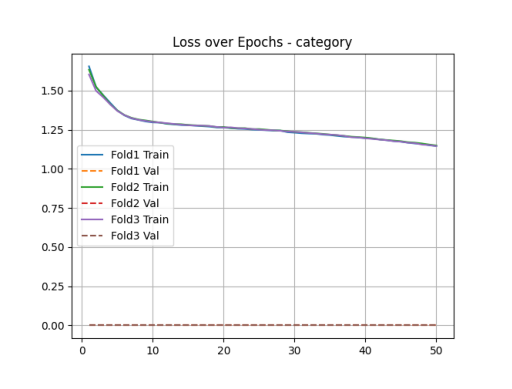

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [51]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,33.14 ± 1.26,34.29 ± 2.87,33.62 ± 0.71,729366.67 ± 611.01
1,Entertainment,18.31 ± 1.07,24.17 ± 2.50,20.80 ± 1.27,343500.00 ± 984.89
2,Food,47.83 ± 0.81,21.54 ± 2.56,29.62 ± 2.23,1727600.00 ± 15062.20
3,Nightlife,15.17 ± 0.54,38.69 ± 1.77,21.77 ± 0.28,267033.33 ± 2285.46
4,Outdoors,18.69 ± 2.30,31.71 ± 4.49,23.32 ± 1.29,382000.00 ± 1646.21


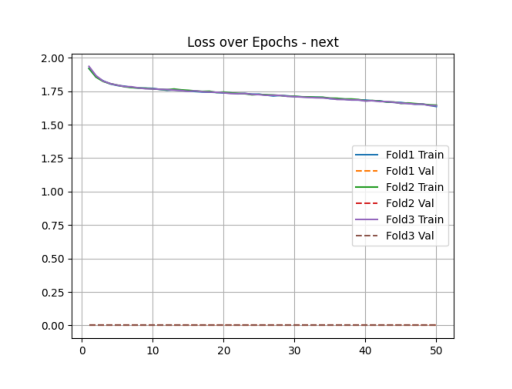

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

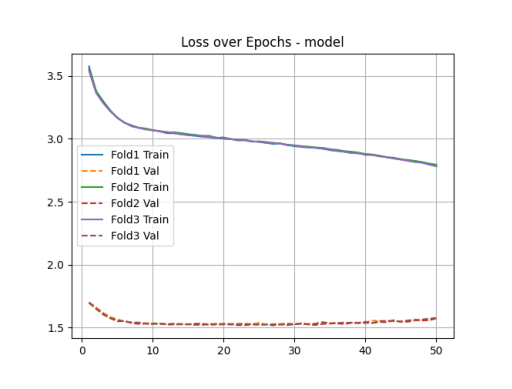

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Alabama

In [1]:
ESTADO = "alabama"

## HGI

In [2]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [20]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [4]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [5]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [6]:
!pip install numpy

In [7]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [29]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [17]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

### checkins filtrados

In [25]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

### pois_gowalla

In [26]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [27]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9531,-0.328018,-0.279717,-0.268858,-0.025124,-0.033602,0.831421,0.487451,0.345670,-0.051999,...,0.382835,0.569170,0.062280,-0.175719,0.631150,-0.055097,0.027944,0.636096,0.206160,Shopping
1,9532,-0.212724,-0.188304,-0.040483,-0.244203,1.012444,1.173037,-0.368704,-0.216277,0.044884,...,-0.090151,0.303618,0.442501,-0.290301,0.510194,-0.057238,-0.213825,0.169952,0.980230,Community
2,9533,0.957083,-0.120902,0.103594,-0.226602,0.106776,0.596069,-0.405396,0.028514,0.509419,...,-0.079732,0.831397,0.024735,-0.035905,0.493928,-0.049237,1.114538,-0.022972,0.607717,Outdoors
3,9593,-0.033946,0.299042,0.101730,-0.204093,0.044489,0.653744,0.662394,0.550874,0.672326,...,-0.085716,0.441036,0.209071,1.268344,-0.063430,-0.185252,0.540702,0.180796,-0.019045,Travel
4,9693,0.615521,-0.025080,-0.066807,-0.233809,-0.017595,0.547271,-0.263094,-0.132398,-0.088840,...,-0.188026,1.086916,-0.036607,-0.170019,0.699518,-0.245074,0.281830,-0.058471,0.175323,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,7565433,-0.317049,-0.118215,-0.024992,-0.075344,-0.097142,0.470303,1.184643,-0.310203,0.385223,...,1.237868,-0.138529,1.750363,-0.187174,0.915760,-0.043957,0.691891,0.626277,0.029799,Food
10265,7568997,0.111724,-0.083904,0.190910,0.032612,-0.245301,0.713871,1.140990,-0.011070,-0.039734,...,0.244286,-0.005502,0.883621,-0.288049,0.223249,-0.191501,0.471388,-0.290527,0.050230,Shopping
10266,7570992,0.049874,-0.004915,-0.391894,0.467625,0.852172,0.454604,0.777993,0.827893,-0.138480,...,0.350916,0.725459,-0.101077,-0.175795,1.246596,0.750474,0.479635,-0.163431,-0.023801,Travel
10267,7574223,-0.295706,0.242828,-0.606082,-0.171838,1.712261,0.892785,1.275130,0.676823,1.093236,...,2.273987,-0.580897,1.323805,0.547652,2.097080,-0.205113,0.026762,-0.269167,0.473824,Food


## Treino com novo modelo de embeddings pelo HGI

In [28]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 1432, Total visit sequences: 10426
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 1432/1432 [00:00<00:00, 18722.47it/s]
nextpoi_sequences shape: (10426, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 2/2 [00:07<00:00,  3.55s/it, rows_written=10426]
Finished: wrote 10426 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Processing complete!


In [30]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-23 21:03:55.217823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761253435.237416    7045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761253435.243346    7045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761253435.258139    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258164    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258169    7045 computation_placer.cc:177] computation placer alr

## Sumário do Treino

In [34]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251023_2104"

### Category

In [35]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,77.41 ± 4.07,75.57 ± 1.23,76.43 ± 1.97,53766.67 ± 57.74
1,Entertainment,71.98 ± 1.99,66.21 ± 0.86,68.96 ± 0.92,19233.33 ± 57.74
2,Food,79.85 ± 0.55,77.89 ± 1.17,78.86 ± 0.80,112633.33 ± 57.74
3,Nightlife,67.37 ± 1.99,63.72 ± 4.08,65.42 ± 2.03,9366.67 ± 57.74
4,Outdoors,71.63 ± 1.75,68.24 ± 2.46,69.89 ± 2.09,16900.00 ± 0.00


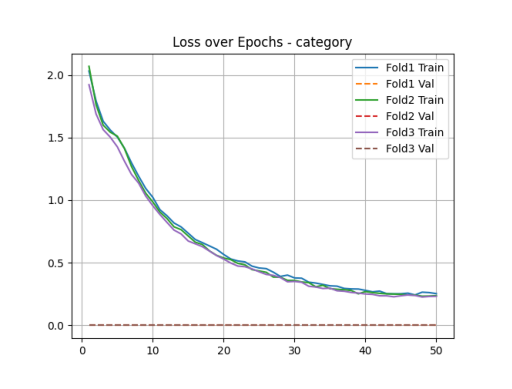

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [37]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,39.23 ± 4.29,49.51 ± 5.02,43.54 ± 2.83,68133.33 ± 57.74
1,Entertainment,15.23 ± 1.78,33.05 ± 10.23,20.33 ± 0.28,20466.67 ± 57.74
2,Food,46.46 ± 4.02,23.77 ± 7.46,30.70 ± 6.14,118366.67 ± 57.74
3,Nightlife,14.41 ± 2.77,34.31 ± 7.86,19.83 ± 1.70,13600.00 ± 0.00
4,Outdoors,13.52 ± 2.40,19.31 ± 9.39,14.92 ± 1.33,16566.67 ± 57.74


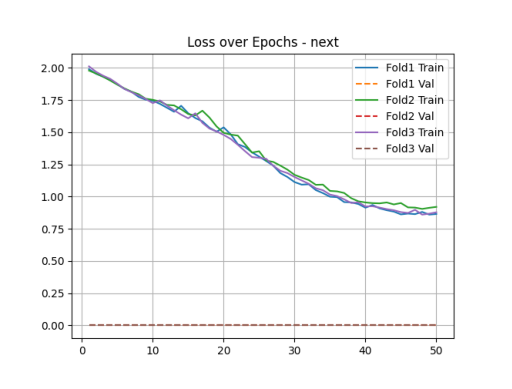

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

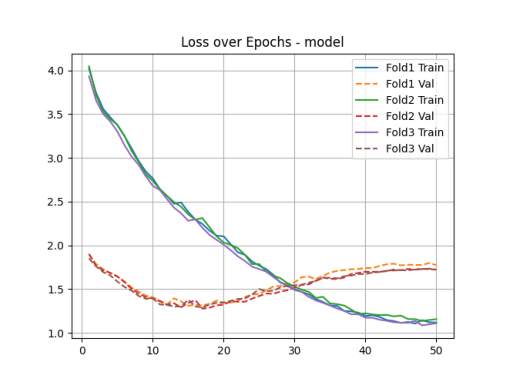

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()